In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session =Session(engine)

# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
previous_year = dt.date(2017, 8, 23)-dt.timedelta(days=365)

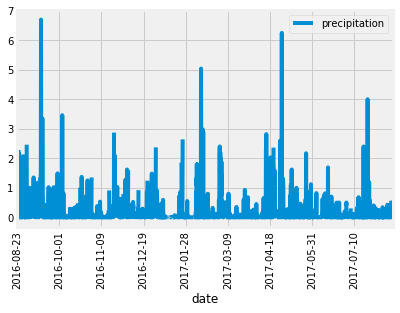

In [21]:
# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= previous_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df =pd.DataFrame(result, columns = ['date', 'precipitation'])
df.set_index(df['date'], inplace =True)
# Sort the dataframe by date
df =df.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot = 90)

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest= session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
highest=session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
average=session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(lowest, highest, average)

[(54.0,)] [(85.0,)] [(71.66378066378067,)]


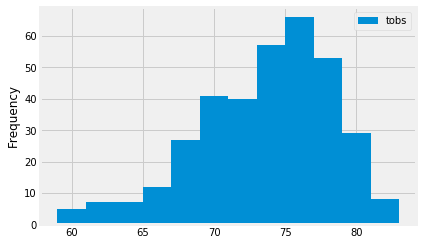

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result1= session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= previous_year).all()
df1 = pd.DataFrame(result1, columns=['tobs'])
df1.plot.hist(bins =12)


## Bonus Challenge Assignment

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt
previous_year_st = dt.date(2018, 1,1)-dt.timedelta(days=365)
pervious_year_end = dt.date(2018, 1, 7)-dt.timedelta(days=365)
tmin, tavg, tmax =calc_temps(previous_year_st.strftime("%Y-%m-%d"), pervious_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

62.0 68.36585365853658 74.0


C:\Users\qinqi\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


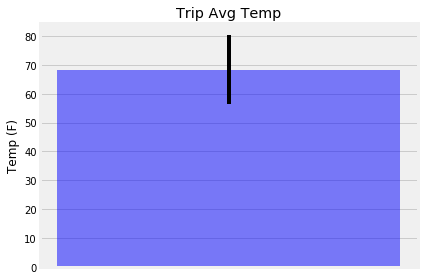

In [55]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()

yerr = tmax-tmin

bar = ax.bar(1, tavg, yerr=yerr, alpha=0.5, color='blue', align="center")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
 
fig.tight_layout()
fig.show()




In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [56]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
